In [54]:
"""
Author: Teng Zeng @UC Berkeley 08.10.2018
"""

'\nAuthor: Teng Zeng @UC Berkeley 08.10.2018\n'

In [55]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats
from scipy.stats import norm

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn import datasets, linear_model
import copy

import EV_chargingstation_planning_inputdata_l2 as ECPinput
import cvxpy as cvx
import pdb

import warnings
warnings.filterwarnings("ignore")

In [56]:
# Read data from excel
e_min_df = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="e_min")
e_max_df = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="e_max")
p_min_df = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="p_min")
p_max_df = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="p_max")
e_min_df_bf = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="e_min_bf")
e_max_df_bf = pd.read_excel("demand_profile.xlsx", index_col=0, sheet_name="e_max_bf")
p_min_df_bf = copy.deepcopy(p_min_df)
p_max_df_bf = copy.deepcopy(p_max_df)

# K-mean Clustering

In [57]:
from sklearn.cluster import KMeans

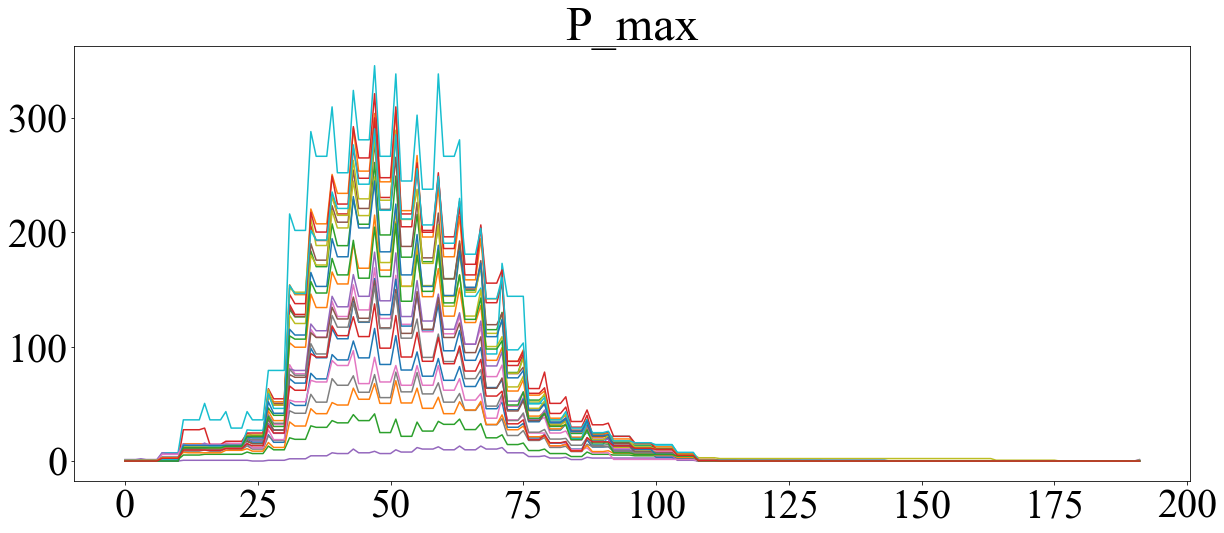

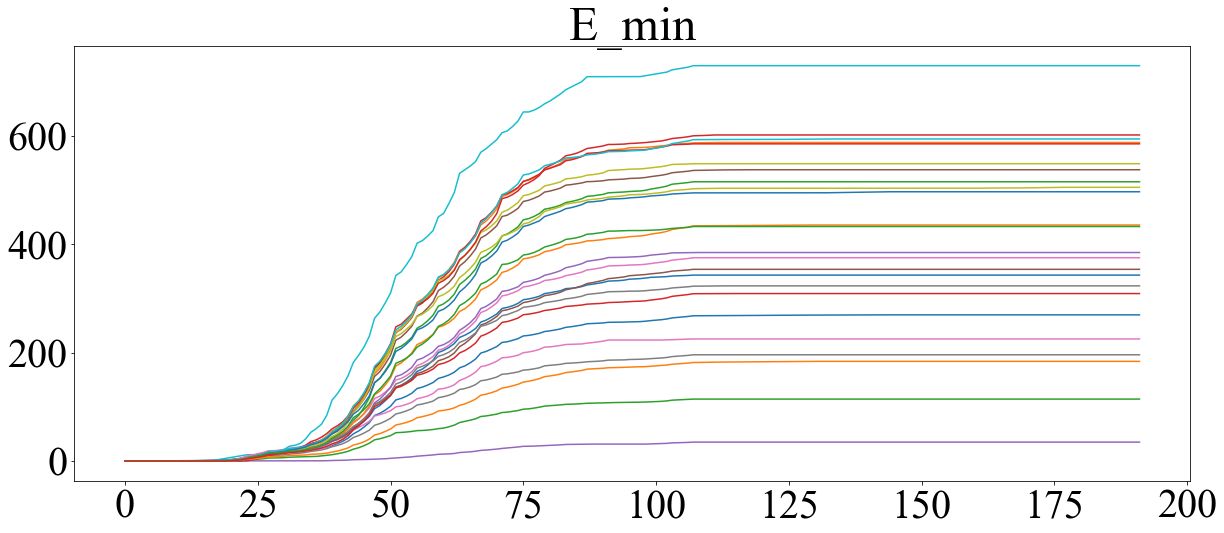

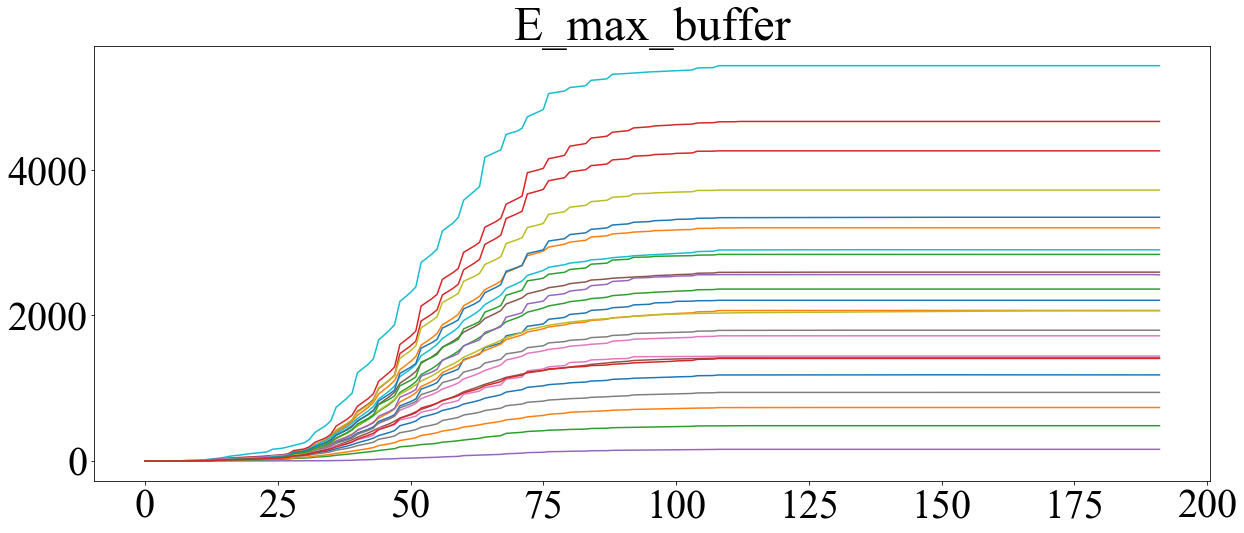

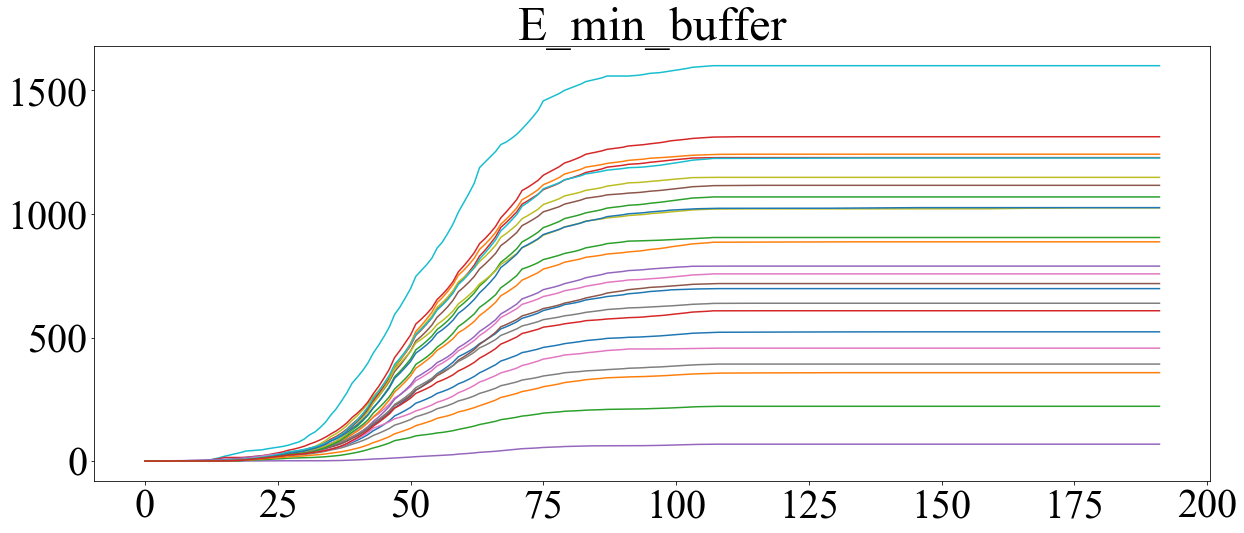

In [58]:
P_E_aggregateDemand = [p_min_df, p_max_df, e_min_df, e_max_df, e_min_df_bf, e_max_df_bf]
giant_df = pd.concat(P_E_aggregateDemand, axis=0)
numb_center = 24
cluster = KMeans(n_clusters=numb_center, random_state=0).fit(giant_df.values.T)

# Assign cluster centers
P_E_clusters_center = list()
for i in range(len(P_E_aggregateDemand)):
    P_E_clusters_center.append(cluster.cluster_centers_[:, i*192:(i+1)*192])

# Assign cluster label size
P_E_clusters_label = np.unique(cluster.labels_, return_counts=True)[1]

# Assign cluster elements
P_E_clusters_elems = [dict() for i in range(6)]
for idx in range(len(P_E_aggregateDemand)):
    for i in range(numb_center):
        P_E_clusters_elems[idx][str(i)] = giant_df.iloc[idx*192:(idx+1)*192, np.where(cluster.labels_==i)[0]]

        
# Sanity Check
plt.figure(figsize=(20,8))
for i in range(numb_center):
    plt.plot(np.arange(192), P_E_clusters_center[1][i]) #p_max
plt.title("P_max")
plt.show()

plt.figure(figsize=(20,8))
for i in range(numb_center):
    plt.plot(np.arange(192), P_E_clusters_center[2][i]) #e_min
plt.title("E_min")
plt.show()

plt.figure(figsize=(20,8))
for i in range(numb_center):
    plt.plot(np.arange(192), P_E_clusters_center[5][i]) #e_max_buffer
plt.title("E_max_buffer")
plt.show()

plt.figure(figsize=(20,8))
for i in range(numb_center):
    plt.plot(np.arange(192), P_E_clusters_center[4][i]) #e_min_buffer
plt.title("E_min_buffer")
plt.show()

In [60]:
def ITC_Coordinated_SP_planning(P_ub_aggregate, P_lb_aggregate, E_ub_aggregate, E_lb_aggregate, \
                                P_ub_aggregate_bf, P_lb_aggregate_bf, E_ub_aggregate_bf, E_lb_aggregate_bf, \
                                P_E_clusters_elems, P_E_clusters_label, day_ticks=96, BaseLoad_profile=None, \
                                PV_profile=None, \
                                Cost_interchange=None, Costs_penalty=None, Cost_charger=None, Cost_ES_P=None, \
                                Cost_ES_E=None, chance_probability=None, p_rated=7.2, numb_center=24):
    """
        All of the Power and Energy aggregate demand, dimensions are now (numb_center x day_ticks*2)
    """

    if BaseLoad_profile == None:
        BaseLoad_profile = ECPinput.BaseLoad_profile
    if PV_profile == None:
        PV_profile = ECPinput.PV_profile
    
    Net_load_profile = ECPinput.Net_Load_profile
    Net_load_profile_sigma = ECPinput.Net_Load_profile_sigma
    
    if Cost_interchange == None:
        Cost_interchange = ECPinput.Cost_interchange
    if Costs_penalty == None:
        Costs_penalty = ECPinput.Cost_penalty
    if Cost_charger== None:
        Cost_charger = ECPinput.Cost_charger
    if Cost_ES_P== None:
        Cost_ES_P = ECPinput.Cost_ES_P
    if Cost_ES_E== None:
        Cost_ES_E = ECPinput.Cost_ES_E
    if chance_probability== None:
        chance_probability = ECPinput.Chance_probability
        
    # Phi^-1(chance_probability)
    chance_pr_inverse_ub = norm.ppf(chance_probability, loc=0, scale=1)
    chance_pr_inverse_lb = norm.ppf(1-chance_probability, loc=0, scale=1)
    
    # Creat decision variables
    x = cvx.Variable(integer=True) # number of chargers
    y = cvx.Variable(1) # energy capacity of ES
    z = cvx.Variable(1) # power capacity of ES
    P_EV = cvx.Variable(shape=(numb_center, day_ticks*2))
    P_EV_loss = cvx.Variable(shape=(numb_center, day_ticks*2)) # unsatisfied demand 
    P_EV_bf = cvx.Variable(shape=(numb_center, day_ticks*2)) # charging power with interchange buffer
    P_EV_bf_interchanged = cvx.Variable(shape=(numb_center, day_ticks*2)) # the demand that is interchanged
    P_grid_net = cvx.Variable(shape=(numb_center, day_ticks*2)) # net grid load
    P_ES_charge = cvx.Variable(shape=(numb_center, day_ticks*2))
    P_ES_discharge = cvx.Variable(shape=(numb_center, day_ticks*2))
    E_ES_initial = cvx.Variable(1) # initial state of energy
    P_grid_net_max = cvx.Variable(1) # peak demand of net load
    
    cost_tot_grand = list() # initialize list to store cost information
    constraints_grand = list() # initialize list to store all constraints
    # Constriants - SP
    for c in range(numb_center):
        
        # constraints, domain & aggregate power , 
        # the power of the EVs should not violate the amount that EVs can actually accept
        constraints = [x >= 0, P_EV>=0, P_EV_loss >=0, P_EV_bf >=0, P_EV_bf_interchanged >=0, P_EV <= P_EV_bf,
                       P_EV[c, :] + P_EV_loss[c, :] >= P_lb_aggregate[c, :],
                       P_EV[c, :] + P_EV_loss[c, :] <= P_ub_aggregate[c, :]]

        # Storage constraints -- 02.16.2019 Not needed for now.
        # power 
        constraints_storage = [P_ES_charge[c, :]>=0, P_ES_discharge[c, :]>=0, P_ES_charge[c, :]<= z, 
                               P_ES_discharge[c, :]<= z, E_ES_initial>=0]
        # energy
        for temp_t in range(0, day_ticks*2):
            constraints_storage += [E_ES_initial \
                                    + ECPinput.delta_time \
                                    * cvx.sum(ECPinput.P_effi * P_ES_charge[c, 0:temp_t+1] \
                                              - P_ES_discharge[c, 0:temp_t+1]/ECPinput.P_effi) >= 0]
            constraints_storage += [E_ES_initial \
                                    + ECPinput.delta_time \
                                    * cvx.sum(ECPinput.P_effi * P_ES_charge[c, 0:temp_t+1] \
                                              - P_ES_discharge[c, 0:temp_t+1]/ECPinput.P_effi) <= y]
        # Energy equilibrium
        constraints_storage += [ECPinput.delta_time \
                                * cvx.sum(ECPinput.P_effi * P_ES_charge[c, :] \
                                          - P_ES_discharge[c, :]/ECPinput.P_effi) == 0]
        # coupled constraints
        constraints_coupled = [P_EV[c, :] + P_ES_charge[c, :] + Net_load_profile \
                               == P_grid_net[c, :] + P_ES_discharge[c, :]]
        # Transformer
        constraints_coupled += [P_grid_net[c, :] <= ECPinput.Transformer_cap, \
                                P_grid_net[c, :] >= -ECPinput.Transformer_cap]

        # peak demand
        constraints_coupled += [P_grid_net_max \
                                - (P_EV[c, :] + P_ES_charge[c, :] - P_ES_discharge[c, :]) >= Net_load_profile]

        # constraints for EVs
        # interchange relationship
        constraints += [P_EV_bf_interchanged[c, :] <= P_ub_aggregate_bf[c, :], \
                        P_EV[c, :] + P_EV_bf_interchanged[c, :] <= P_ub_aggregate_bf[c, :]]

        # constraints, Aggregate energy, the cummulative energy consumption should satisfy the demands
        for temp_t in range(0, day_ticks*2):
            # actual energy constraint
            constraints += [ECPinput.P_effi * ECPinput.delta_time \
                            * cvx.sum(P_EV[c, 0:temp_t+1] + P_EV_loss[c, 0:temp_t+1]) \
                            >= E_lb_aggregate[c, temp_t]]

            # plug in energy constraint
            constraints += [ECPinput.P_effi * ECPinput.delta_time * cvx.sum(P_EV_bf_interchanged[c, :temp_t+1])\
                       <= (ECPinput.P_effi * ECPinput.delta_time * np.sum(P_ub_aggregate_bf[c, :temp_t+1]) \
                           - E_lb_aggregate_bf[c, temp_t])]

        # constraints, the EV charging power should not violate the capacity that chargers can actually provide
        # For charger constraint, we use chance constrained 
        constraints += [np.quantile(P_E_clusters_elems[1][str(c)].iloc[:96, :].values \
                                    + P_E_clusters_elems[1][str(c)].iloc[96:, :].values, q=1-chance_probability, axis=1)\
                       <= P_EV_bf_interchanged[c, 0:day_ticks] + P_EV_bf_interchanged[c, day_ticks:] + p_rated*x]

        # Electricity costs
        Costs_electricity = 365 * ECPinput.delta_time * \
        cvx.sum(np.hstack((ECPinput.TOU-0.33, ECPinput.TOU-0.33)) * P_grid_net[c, :]) 
        # Electricity costs
        Costs_electricity_demandcharge = 12*ECPinput.Demand_charge_price*P_grid_net_max 
        # Interchange labor costs
        Costs_interchange = 365*ECPinput.delta_time*Cost_interchange*cvx.sum(P_EV_bf_interchanged[c, :]) 
        # Penalty for EV loss
        CostsPenalty = 365*ECPinput.delta_time*Costs_penalty*cvx.sum(P_EV_loss[c, :]) 
        # Penalty for EV loss
        Costs_penalty_smooth = 365*0.0001*cvx.sum_squares(P_grid_net[c, :]) 

        cost_tot_grand.append([Costs_electricity, Costs_electricity_demandcharge, Costs_interchange, \
                    CostsPenalty, Costs_penalty_smooth]) #store scenario specific cost information
        
        constraints_grand.extend(constraints+constraints_storage+constraints_coupled)
        
    # Capital investment 
    Costs_investment = ECPinput.Capital_recover_factor*(Cost_charger*x + Cost_ES_E*y + Cost_ES_P*z) 
    
    cost = 0
    # Objective
    for cost_idx, cost_list in enumerate(cost_tot_grand):
        cost += P_E_clusters_label[cost_idx]/sum(P_E_clusters_label)*cvx.sum(cost_list)
    obj = cvx.Minimize(Costs_investment + cost)
    
    # Solve problem
    prob = cvx.Problem(obj, constraints_grand)
    
    # solve the problem, here we adopted the solver gurobi
    result = prob.solve(solver="GUROBI", verbose=False)
    

    cost_tot_grand = np.array(cost_tot_grand) #convert to array for indexing convenience
    # assign to variables
    Costs_electricity = np.dot(P_E_clusters_label/sum(P_E_clusters_label), cost_tot_grand[:, 0]).value
    Costs_electricity_demandcharge = np.dot(P_E_clusters_label/sum(P_E_clusters_label), cost_tot_grand[:, 1]).value
    Costs_interchange = np.dot(P_E_clusters_label/sum(P_E_clusters_label), cost_tot_grand[:, 2]).value
    CostsPenalty = np.dot(P_E_clusters_label/sum(P_E_clusters_label), cost_tot_grand[:, 3]).value
    Costs_penalty_smooth = np.dot(P_E_clusters_label/sum(P_E_clusters_label), cost_tot_grand[:, 4]).value
#     pdb.set_trace()                                         
    # Optimizaiton output
    print("Coordinated charging with interchange & delay:", prob.status)
    print("optimal value", prob.value)
    print("Number of charger value:", x.value)
    print("Energy capacity of ES:", y.value)
    print("Power capacity of ES:", z.value)
    print("Investment costs:", Costs_investment.value)
    print("Electricity costs:", Costs_electricity)
    print("Electricity costs (demand charge):", Costs_electricity_demandcharge)
    print("Interchange costs:", Costs_interchange)
    print("Penalty costs:", CostsPenalty)
    print("Penalty costs smooth:", Costs_penalty_smooth)
    
#     return P_EV.value
    
    return [x.value, Costs_investment.value + Costs_electricity + Costs_electricity_demandcharge \
                      + Costs_interchange + CostsPenalty + Costs_penalty_smooth, \
                      Costs_investment.value, Costs_electricity, Costs_electricity_demandcharge, \
            Costs_interchange, Costs_penalty_smooth]

In [255]:
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
# P_E_aggregateDemand = [p_min_df, p_max_df, e_min_df, e_max_df, e_min_df_bf, e_max_df_bf]

result_list_separate = [[] for i in range(7)] #a list of list, each sub-list consists of 
                                                    #[x, tot_cost, inv_cost, elec_cost, elec_dem_cost, 
                                                    #itc_cost, penalty_smooth]
cc_list = np.linspace(0.1, 0.5, 5)
result_dict = {}
for cc in cc_list:
    result_dict["{}".format(round(cc,2))] = copy.deepcopy(result_list_separate)

In [262]:
result_dict_12 = copy.deepcopy(result_dict)

In [269]:
# ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
# # P_E_aggregateDemand = [p_min_df, p_max_df, e_min_df, e_max_df, e_min_df_bf, e_max_df_bf]

# result_list_separate = [[] for i in range(7)] #a list of list, each sub-list consists of 
#                                                     #[x, tot_cost, inv_cost, elec_cost, elec_dem_cost, 
#                                                     #itc_cost, penalty_smooth]
# cc_list = np.linspace(0.1, 0.5, 5)
itc_price_list = [0.003, 0.1, 0.2, 0.3, 0.44, 10]
# itc_price_list = [0.003]
charger_price_list = [500, 1000, 2000, 3000, 4000]
# charger_price_list = [500]

for cc in cc_list[2:]:
    result_list_separate = result_dict["{}".format(round(cc,2))]
    for itc_price in itc_price_list:
        for charger_price in charger_price_list:
            print("Interchange cost = {}, charger cost = {}".format(itc_price, charger_price))
            result_list = ITC_Coordinated_SP_planning(P_E_clusters_center[1], P_E_clusters_center[0], \
                                                      P_E_clusters_center[3], P_E_clusters_center[2], \
                                                      P_E_clusters_center[1], P_E_clusters_center[0], \
                                                      P_E_clusters_center[-1], P_E_clusters_center[-2],\
                                                      P_E_clusters_elems, P_E_clusters_label, \
                                                      day_ticks=96, BaseLoad_profile=None, \
                                                      PV_profile=None, Cost_interchange=itc_price, \
                                                      Costs_penalty=None, Cost_charger=charger_price,\
                                                      Cost_ES_P=10000000, Cost_ES_E=10000000, \
                                                      chance_probability=cc, p_rated=7.2, numb_center=numb_center)

            # Append to stored list
            for cost_idx, cost_elem in enumerate(result_list):
                if cost_idx == 0:
                    result_list_separate[cost_idx].append(np.round(cost_elem))                
                else:
                    result_list_separate[cost_idx].append(cost_elem)
    result_dict["{}".format(round(cc,2))] = result_list_separate

Interchange cost = 0.003, charger cost = 500
Coordinated charging with interchange & delay: optimal
optimal value 177012.09441952017
Number of charger value: 19.000000000000004
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [978.14625758]
Electricity costs: -373233.36448170827
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 266.0099142857137
Penalty costs: 0.0
Penalty costs smooth: 455387.39647976105
Interchange cost = 0.003, charger cost = 1000
Coordinated charging with interchange & delay: optimal
optimal value 177966.06739965238
Number of charger value: 18.0
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [1853.3297512]
Electricity costs: -373202.960664008
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 306.0435057006396
Penalty costs: 0.0
Penalty costs smooth: 455395.74855715927
Interchange cost = 0.003, charger cost = 2000
Coordinated charging with interchange & delay: optimal
optimal va

Coordinated charging with interchange & delay: optimal
optimal value 191177.2216008718
Number of charger value: 33.99999999999997
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [14002.93589792]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 1448.215714285713
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 0.44, charger cost = 500
Coordinated charging with interchange & delay: optimal
optimal value 177991.01467458234
Number of charger value: 42.0
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [2162.21804306]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 102.72664285714056
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 0.44, charger cost = 1000
Coordinated charging with interchange & delay: optimal
optimal value 180107.91388226039
Number of charger value: 

Coordinated charging with interchange & delay: optimal
optimal value 186089.36124464084
Number of charger value: 29.999999999999996
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [9266.64875598]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 1096.6424999999942
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 0.1, charger cost = 4000
Coordinated charging with interchange & delay: optimal
optimal value 189046.02856488604
Number of charger value: 27.0
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [11119.97850717]
Electricity costs: -373275.17706642265
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 2199.8941071428485
Penalty costs: 0.0
Penalty costs smooth: 455387.42676738783
Interchange cost = 0.2, charger cost = 500
Coordinated charging with interchange & delay: optimal
optimal value 177880.19919634238
Number of charger valu

Coordinated charging with interchange & delay: optimal
optimal value 185001.8825024453
Number of charger value: 44.0
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [9060.72322807]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 215.08928571428228
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 10, charger cost = 3000
Coordinated charging with interchange & delay: optimal
optimal value 189532.24411647875
Number of charger value: 44.0
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [13591.0848421]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 215.08928571428228
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 10, charger cost = 4000
Coordinated charging with interchange & delay: optimal
optimal value 193983.16538897748
Number of charger value: 43.0
Energy capa

Coordinated charging with interchange & delay: optimal
optimal value 179886.20323325045
Number of charger value: 37.99999999999997
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [3912.5850303]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 247.54821428571378
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 0.3, charger cost = 2000
Coordinated charging with interchange & delay: optimal
optimal value 183589.87685838973
Number of charger value: 34.99999999999997
Energy capacity of ES: [0.]
Power capacity of ES: [0.]
Investment costs: [7207.39347687]
Electricity costs: -373275.39594421285
Electricity costs (demand charge): [93613.9062496]
Interchange costs: 656.4133928571423
Penalty costs: 0.0
Penalty costs smooth: 455387.559683271
Interchange cost = 0.3, charger cost = 3000
Coordinated charging with interchange & delay: optimal
optimal value 187109.6095130956
Number of charg

In [273]:
# result_df = pd.DataFrame(result_dict)
# result_df.to_excel("planning_result_dict.xlsx")

# Aggregate results

In [635]:
result_dict

{'0.1': [[22.0,
   19.0,
   19.0,
   19.0,
   19.0,
   40.0,
   38.0,
   34.0,
   32.0,
   31.0,
   43.0,
   40.0,
   38.0,
   35.0,
   35.0,
   44.0,
   42.0,
   39.0,
   38.0,
   36.0,
   46.0,
   43.0,
   41.0,
   39.0,
   38.0,
   51.0,
   50.0,
   50.0,
   50.0,
   47.0],
  [array([177148.68878002]),
   array([178223.38265304]),
   array([180179.67516819]),
   array([182135.96768334]),
   array([184092.26019849]),
   array([177988.2913392]),
   array([180006.92698325]),
   array([183707.60204477]),
   array([187189.09425694]),
   array([190440.40182626]),
   array([178091.89619942]),
   array([180250.51268973]),
   array([184287.78397784]),
   array([188066.7187754]),
   array([191670.41551384]),
   array([178147.75758139]),
   array([180378.41946764]),
   array([184577.94629146]),
   array([188568.64097243]),
   array([192384.68210537]),
   array([178187.99248821]),
   array([180488.14776731]),
   array([184825.64120443]),
   array([188976.52508572]),
   array([192996.80675273]),

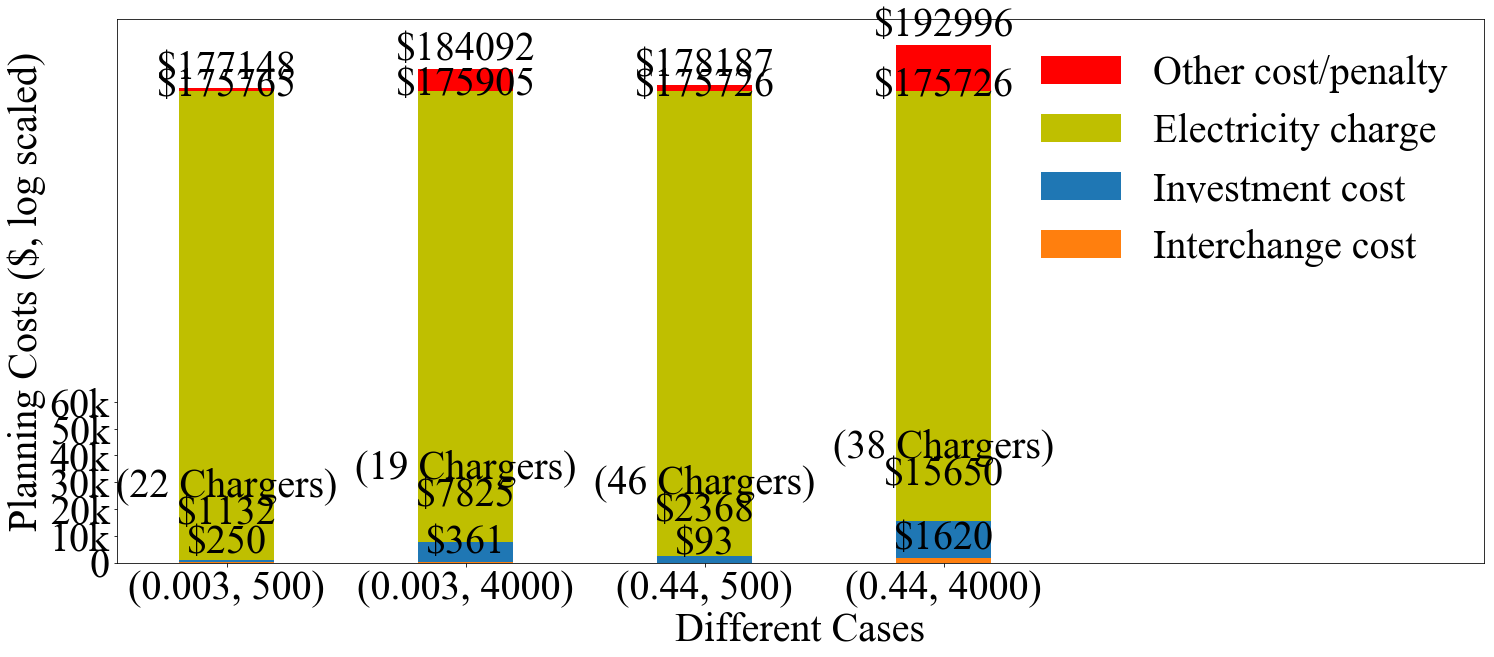

In [67]:
# Matplotlib visualization total
result_list_separate = result_dict["0.1"]
# Extract Results
itc_result = result_list_separate[0] + [0]

total_cost = result_list_separate[1]+[0]

inv_cost = result_list_separate[2]+[0]

elec_cost = result_list_separate[3]+[0]

elec_dem_cost = result_list_separate[4]+[0]

itc_cost = result_list_separate[5]+[0]

penalty_smooth = result_list_separate[6]+[0]

cost_tot_other = np.array(elec_cost) + np.array(elec_dem_cost) + np.array(penalty_smooth)

# Plot results
plt.figure(figsize=(24.5, 10))
plt.rc("font", size = 40, family = "Times New Roman")

totCost_xaxis = [0, 1, 2, 3, 4.8]
inv_Cost_xaxis = [0, 1, 2, 3, 4.8]
itc_Cost_xaxis = [0, 1, 2, 3, 4.8]

bar1 = plt.bar(totCost_xaxis, total_cost, width=0.4, label="Other cost/penalty", log=False, color = 'r')
# plt.bar(totCost_xaxis, elec_cost, width=0.4, label="Electricity cost", log=True)
# plt.bar(totCost_xaxis, elec_dem_cost, width=0.4, label="Demand charge", log=True)
bar4 = plt.bar(totCost_xaxis, cost_tot_other, width=0.4, label="Electricity charge", log=False, color = 'y')
bar2 = plt.bar(inv_Cost_xaxis, inv_cost, width=0.4, label="Investment cost", log=False)
bar3 = plt.bar(itc_Cost_xaxis, itc_cost, width=0.4, label="Interchange cost", log=False)

# plt.bar(totCost_xaxis, penalty_smooth, width=0.2, label="Smoothing penalty", log=True)

plt.xticks([0, 1, 2, 3], ["(0.003, 500)", "(0.003, 4000)", "(0.44, 500)", "(0.44, 4000)"])
plt.xlabel("Different Cases")
plt.ylabel("Planning Costs ($, log scaled)")
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000,], ["0", "10k", "20k", "30k", "40k", "50k", "60k"])

#add text to total cost bar
idx = 0
for rect in bar1[:-1]:
    height = rect.get_height() #1300000
    plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (total_cost[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
#add text to investment cost bar
idx = 0
for rect in bar2[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height+10000, '$%d' % (inv_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    if idx == 0:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    else:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
        
    idx += 1
    
#add text to interchange cost bar
idx = 0
for rect in bar3[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    if idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx > 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+60, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1

#add text to electricty cost bar
idx = 0
for rect in bar4[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height-5000, '$%d' % (cost_tot_other[idx][0]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
    
plt.legend(fontsize=40, framealpha=0)

# Plotly

In [634]:
np.array(result_dict["0.5"][0]).reshape(6,5) #axis 0: ITC price, axis 1: charger price

array([[18., 18., 18., 18., 18.],
       [36., 33., 30., 29., 27.],
       [39., 36., 33., 31., 30.],
       [40., 38., 35., 33., 32.],
       [41., 39., 36., 35., 34.],
       [47., 43., 43., 43., 42.]])

In [69]:
import plotly.plotly as py
import plotly.graph_objs as go

In [274]:
result_list_separate = result_dict["0.1"]
invest_cost = [float(i) for i in result_list_separate[2]] #2: cost of investment
numb_chargers = result_list_separate[0] #)0: number of chargers

In [549]:
trace = go.Heatmap(z=[[float(i) for i in result_dict["0.1"][2]] , 
                      [float(i) for i in result_dict["0.2"][2]], 
                      [float(i) for i in result_dict["0.3"][2]][3:],
                      [float(i) for i in result_dict["0.4"][2]],
                      [float(i) for i in result_dict["0.5"][2]]],
                   x=["({},{})".format(i, j) for i in itc_price_list for j in charger_price_list],
                   y=list(result_dict))
data=[trace]
py.iplot(data, filename='labelled-heatmap')

In [285]:
z = [[float(i) for i in result_dict["0.1"][2]] , 
                      [float(i) for i in result_dict["0.2"][2]], 
                      [float(i) for i in result_dict["0.3"][2]][3:],
                      [float(i) for i in result_dict["0.4"][2]],
                      [float(i) for i in result_dict["0.5"][2]]]
z = np.matrix(z)

In [300]:
layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='Sensitivity Analysis',
    scene=dict(
        xaxis=dict(
            title='($ITC, #Charger)',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            tickvals=[i for i in range(30)],
            ticktext=["{},{}".format(i, j) for i in itc_price_list for j in charger_price_list],
            tickangle = 80,
            showticklabels=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Reliability Factor',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            tickvals=[0, 1, 2, 3, 4],
            ticktext=["0.1", "0.2", "0.3", "0.4", "0.5",],
            tickangle = 20,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='Investment Cost',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

data = [go.Surface(z=z)]
fig = go.Figure(data=data, layout=layout)
camera = dict(
    up=dict(x=0, y=0, z=0.1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1, y=1.7, z=0.85)
)

fig['layout'].update(
    scene=dict(camera=camera)
)
py.iplot(fig, filename='elevations-3d-surface')

# import plotly.io as pio
# pio.write_image(fig, 'fig1.pdf')

# Matplotlib

In [360]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

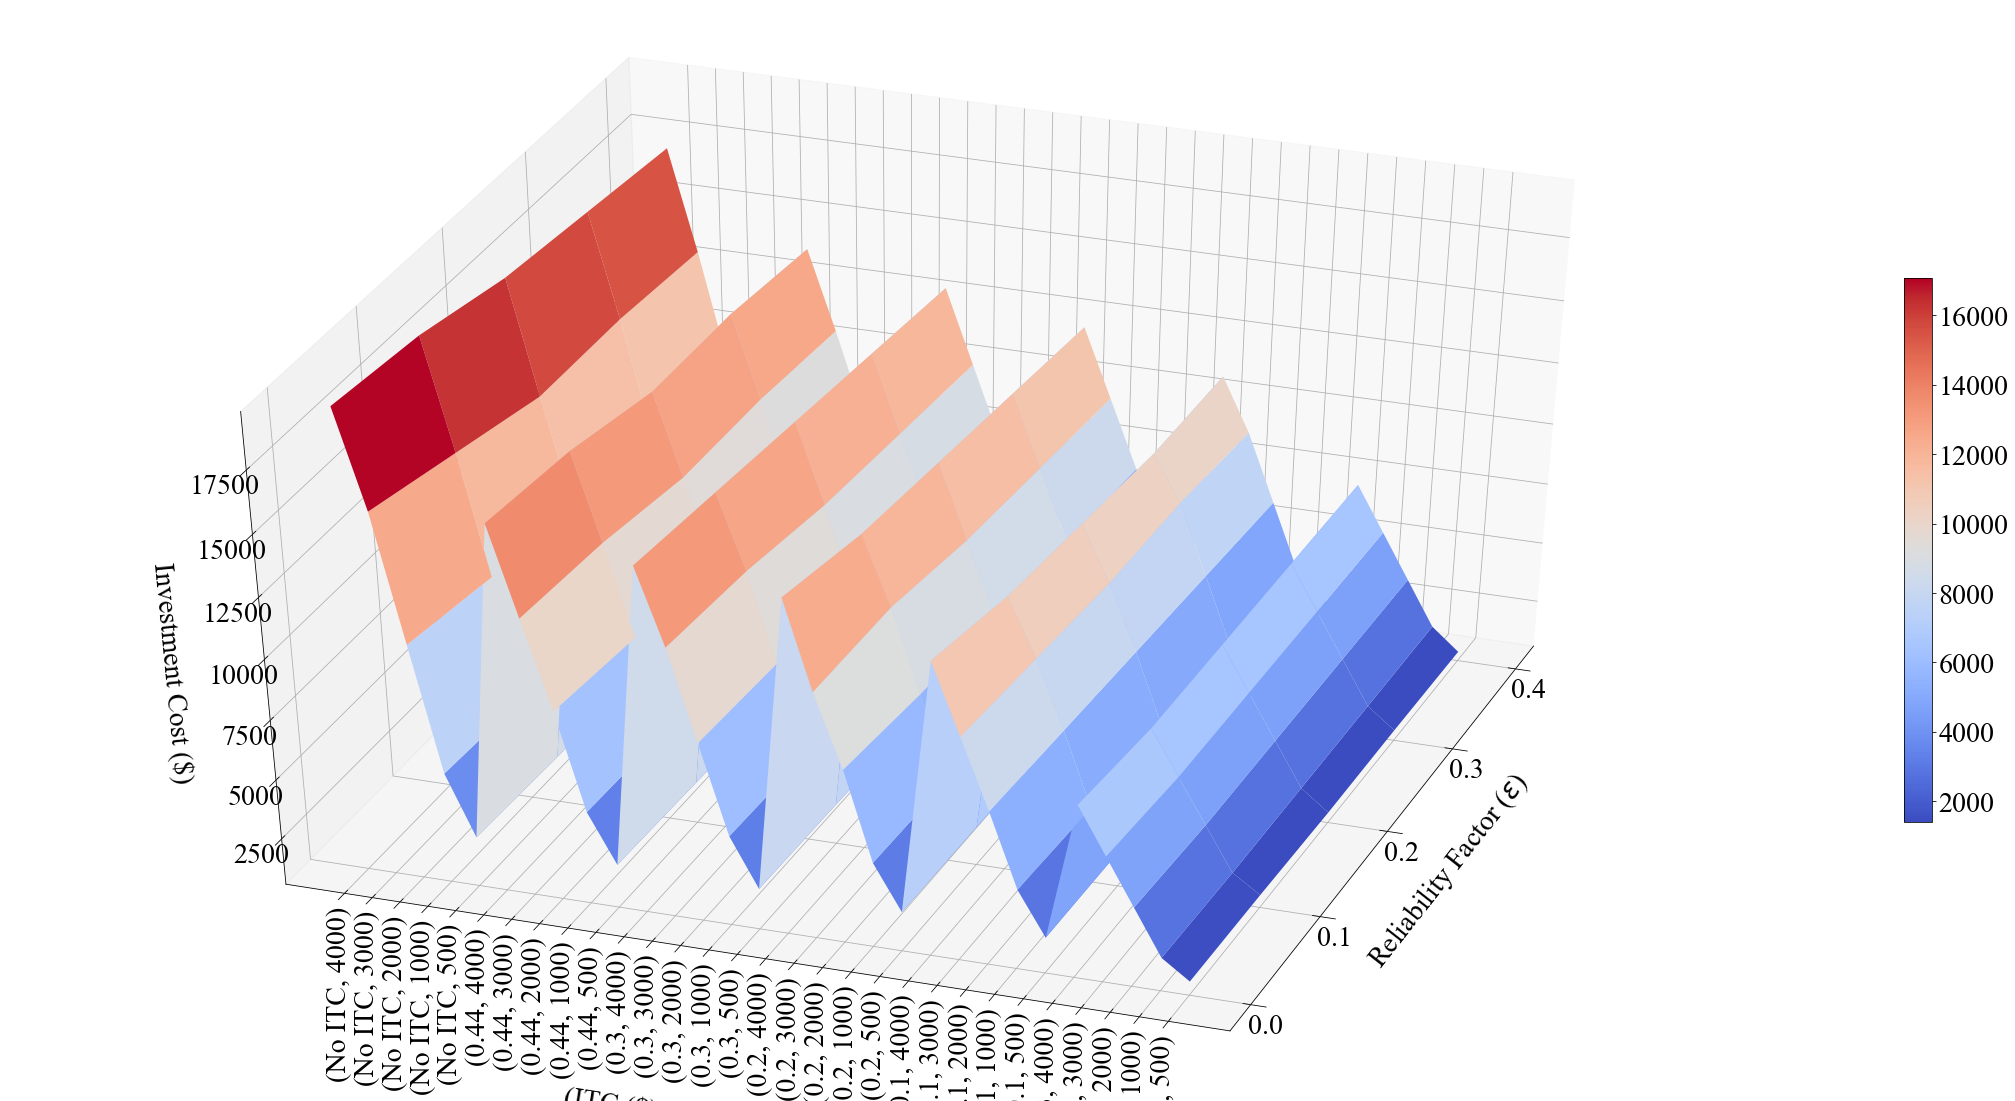

In [423]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 28}
plt.rc('font', **font)
fig = plt.figure(figsize=(40, 20))
ax = plt.axes(projection='3d')
x = [0, 1, 2, 3, 4]
y = [i for i in range(30)]
X, Y = np.meshgrid(x,y)
p = ax.plot_surface(X.T, Y.T, z, rstride=1, cstride=1, cmap=cm.coolwarm, edgecolor='none')

#Set labels and ticks
ax.set_xlabel('Reliability Factor ($\epsilon$)', labelpad=30)
ax.set_xticks(x)
ax.set_xticklabels(["0.{}".format(i) for i in x])

ax.set_ylabel('(ITC (\$), Charger (\$))', labelpad=120)
ax.set_yticks(y)
itc_price_list_temt = itc_price_list
itc_price_list_temt[-1] = "No ITC"
ax.set_yticklabels(["({}, {})".format(i, j) for i in itc_price_list for j in charger_price_list], fontsize=28)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)

ax.set_zlabel('Investment Cost ($)', labelpad=30)

fig.colorbar(p, shrink=0.5) #color bar
ax.view_init(40, 200) #set camera view

# plt.savefig("output_figures/sensitivity_itc_charger_reliability.pdf")

### 3D bar plot - different view

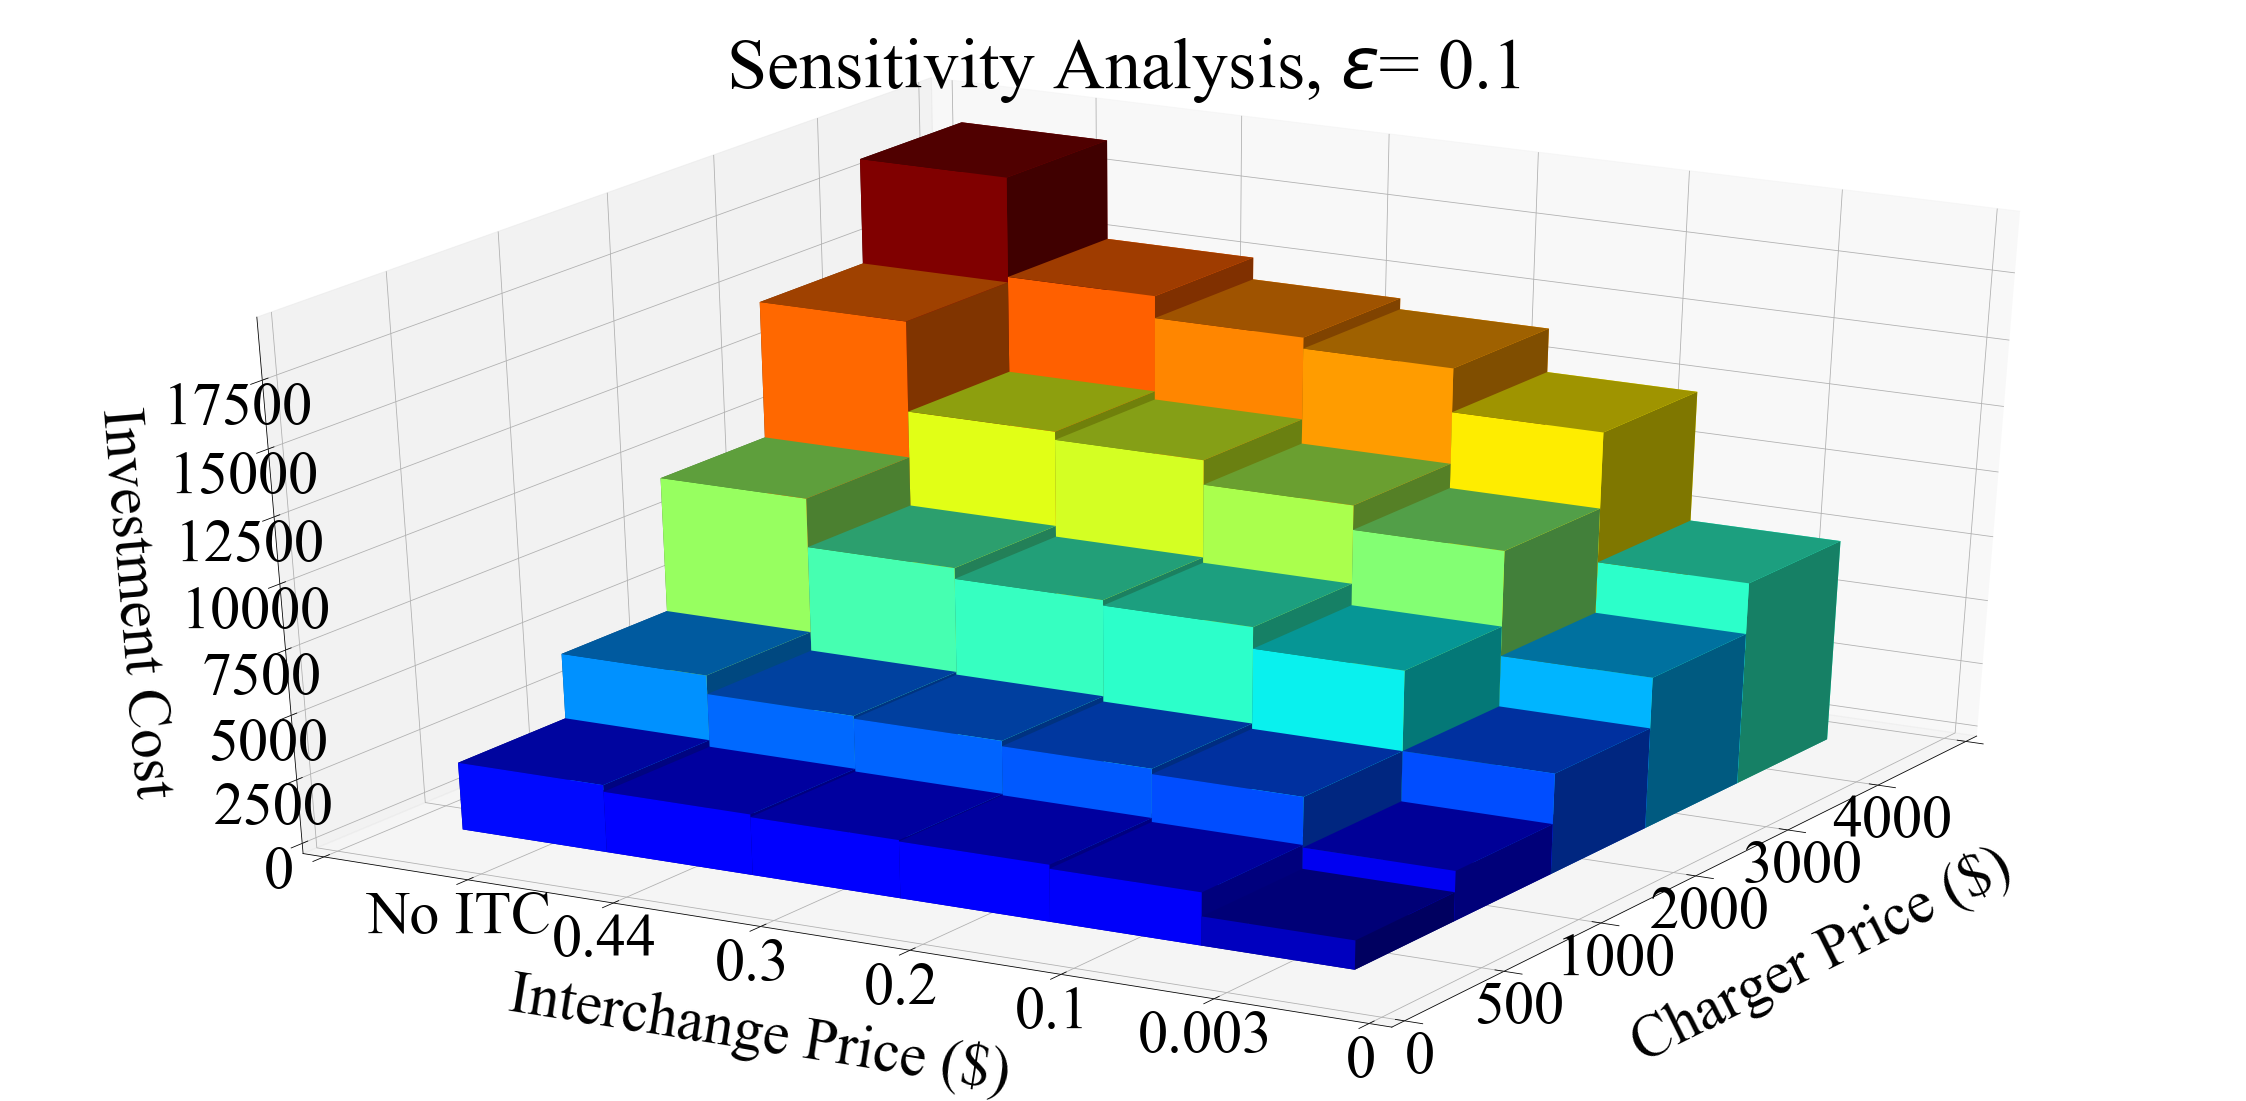

In [567]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 60}
plt.rc('font', **font)
fig = plt.figure(figsize=(40, 20))
ax = plt.axes(projection='3d')

x = np.arange(5)
y = np.arange(6)
X, Y = np.meshgrid(x-0.5,y-0.5)

xpos = X.flatten()
ypos = Y.flatten()
zpos = np.zeros(len(x)*len(y))

dx = np.ones_like(zpos)
dy = dx.copy()
dz = np.array([float(i) for i in result_dict["0.1"][2]])

#Set color
cs = ['r', 'g', 'b', 'y', 'c'] * len(y)

#Plot
colors = plt.cm.jet(dz/dz.max()) # color Bar
p = ax.bar3d(xpos, ypos, zpos,dx, dy, dz, color=colors, shade=True)

#Set Axes
ax.set_xlabel('Charger Price ($)', labelpad=80)
ax.set_xticklabels([0]+["{}".format(i) for i in charger_price_list])
ax.set_xlim([-1, 5])

ax.set_ylabel('Interchange Price ($)', labelpad=80)
ax.set_yticklabels([0]+["{}".format(i) for i in itc_price_list])
ax.set_ylim([-1, 6])

ax.set_zlabel('Investment Cost', labelpad=50)

#Set title
ax.set_title("Sensitivity Analysis, $\epsilon$= 0.1")

ax.view_init(30, 210) #set camera view

# plt.savefig("output_figures/sensitivity_itc_charger_reliability_barplot.pdf")

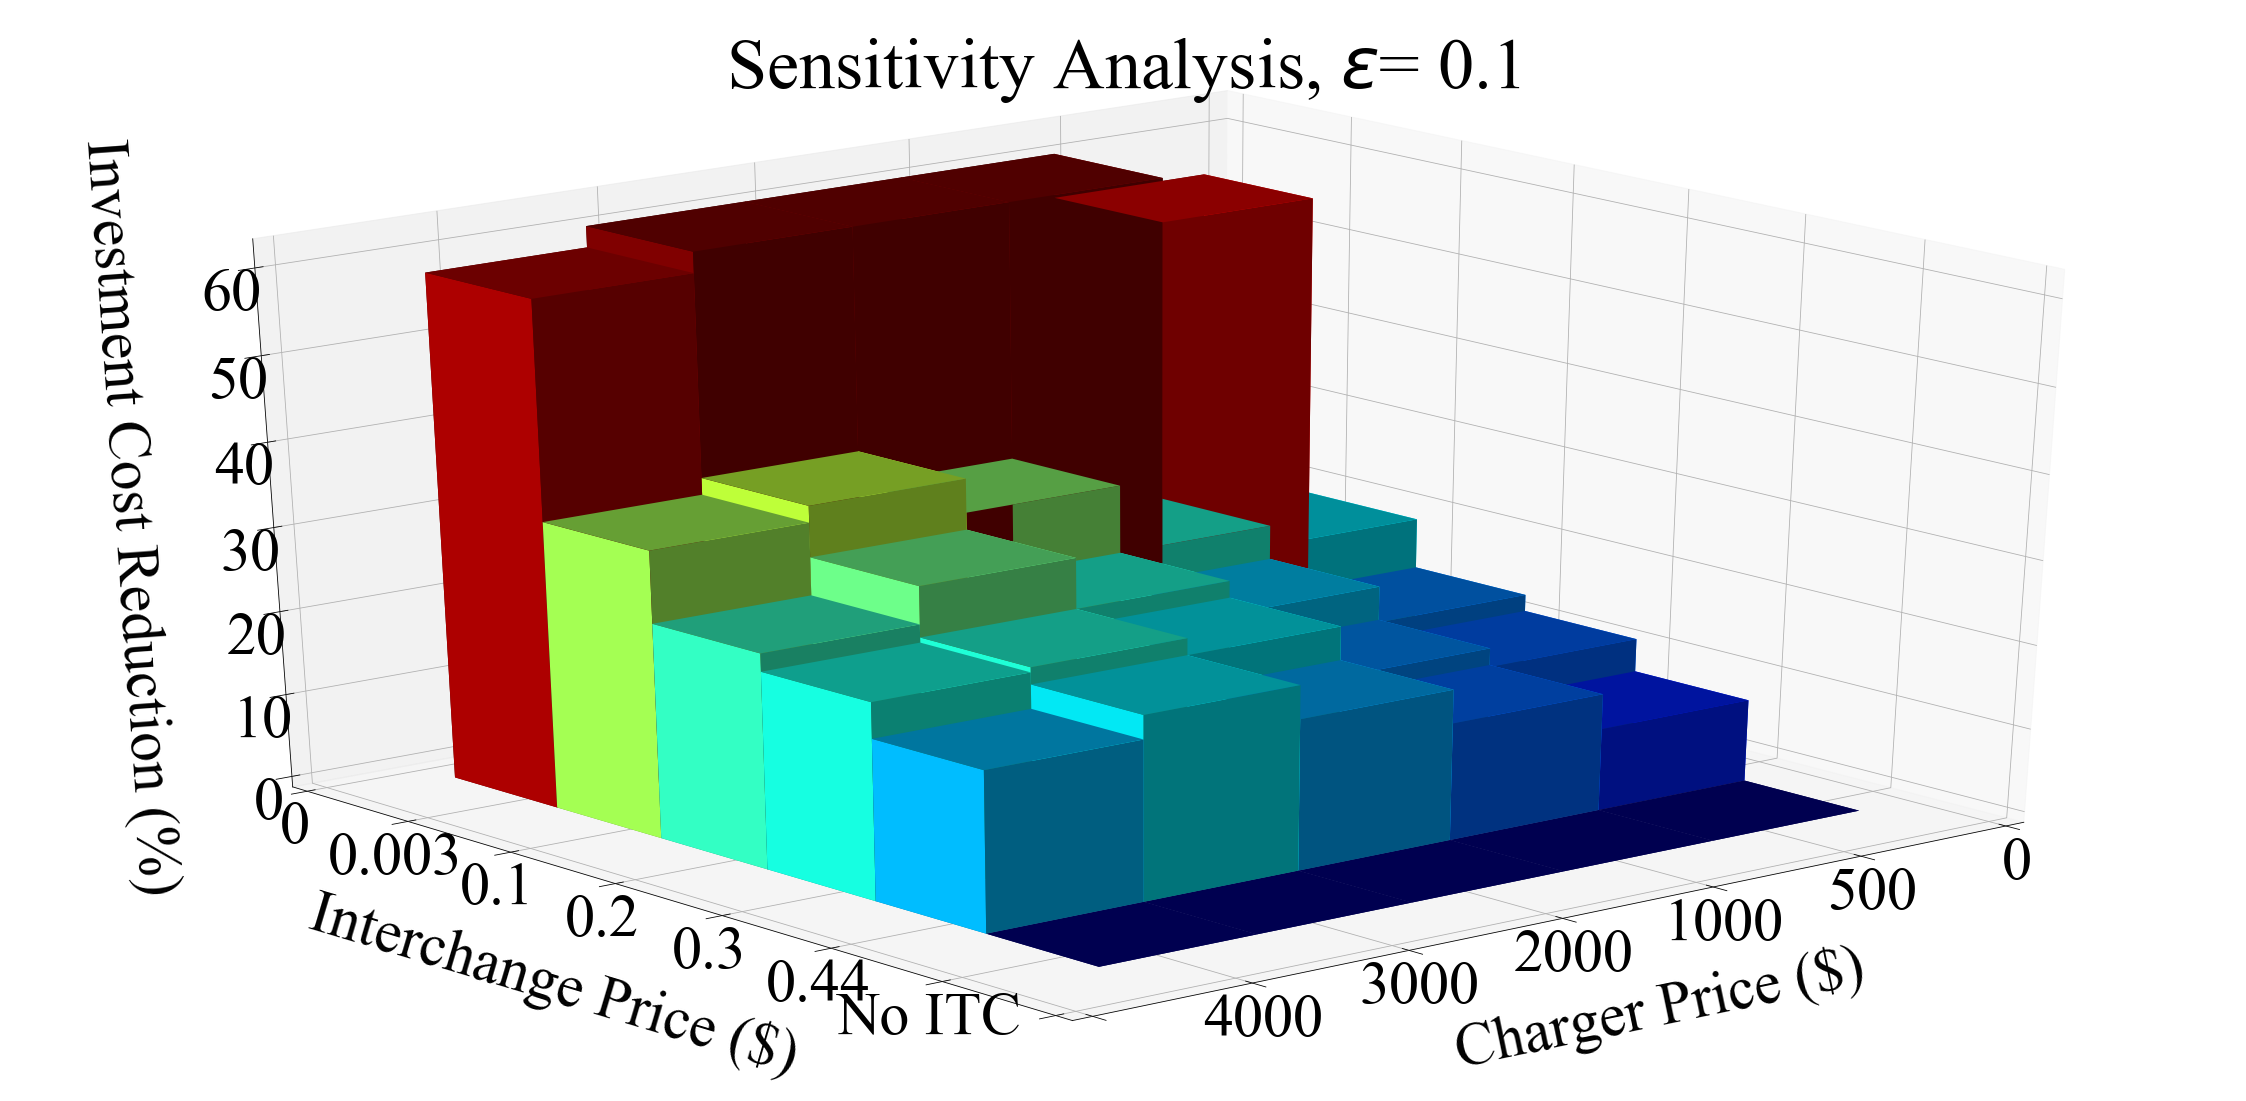

In [622]:
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 60}
plt.rc('font', **font)
fig = plt.figure(figsize=(40, 20))
ax = plt.axes(projection='3d')

x = np.arange(5)
y = np.arange(6)
X, Y = np.meshgrid(x-0.5,y-0.5)

xpos = X.flatten()
ypos = Y.flatten()
zpos = np.zeros(len(x)*len(y))

# calculate cost reduction
dz_percentage = np.ones((6,5)) #initialize a matrix
for i in range(6):    
    dz_percentage[i, :] = -(dz.reshape(6,5)[i, :] - dz.reshape(6,5)[-1, :])/dz.reshape(6,5)[-1, :]

dx = np.ones_like(zpos)
dy = dx.copy()
dz_ = dz_percentage.flatten()*100

#Set color
cs = ['r', 'g', 'b', 'y', 'c'] * len(y)

#Plot
colors = plt.cm.jet(dz_/dz_.max()) # color Bar
p = ax.bar3d(xpos, ypos, zpos,dx, dy, dz_, color=colors, shade=True)

#Set Axes
ax.set_xlabel('Charger Price ($)', labelpad=80)
ax.set_xticklabels([0]+["{}".format(i) for i in charger_price_list])
ax.set_xlim([-1, 5])

ax.set_ylabel('Interchange Price ($)', labelpad=80)
ax.set_yticklabels([0]+["{}".format(i) for i in itc_price_list])
ax.set_ylim([-1, 6])

ax.set_zlabel('Investment Cost Reduction (%)', labelpad=50)

#Set title
ax.set_title("Sensitivity Analysis, $\epsilon$= 0.1")

ax.view_init(26, 50) #set camera view

# plt.savefig("output_figures/sensitivity_itc_charger_reliability_barplot_costReduction.pdf")

In [625]:
dz_percentage*100

array([[56.8627451 , 62.        , 62.        , 62.        , 59.57446809],
       [21.56862745, 24.        , 32.        , 36.        , 34.04255319],
       [15.68627451, 20.        , 24.        , 30.        , 25.53191489],
       [13.7254902 , 16.        , 22.        , 24.        , 23.40425532],
       [ 9.80392157, 14.        , 18.        , 22.        , 19.14893617],
       [-0.        , -0.        , -0.        , -0.        , -0.        ]])

# Below plot out planning result corresponding to Chance Constraint $\epsilon$

## $\epsilon$ = 0.05

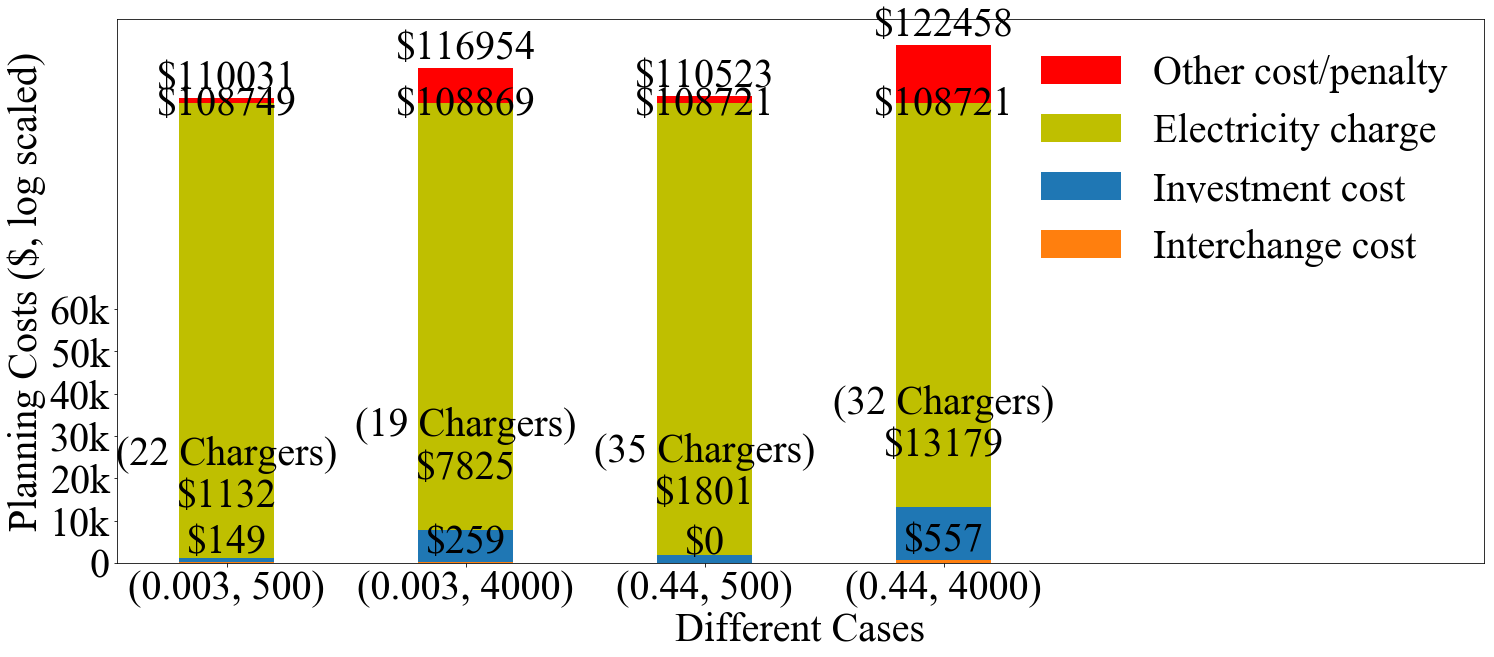

In [7]:
# Extract Results
itc_result = result_list_separate[0] + [0]

total_cost = result_list_separate[1]+[0]

inv_cost = result_list_separate[2]+[0]

elec_cost = result_list_separate[3]+[0]

elec_dem_cost = result_list_separate[4]+[0]

itc_cost = result_list_separate[5]+[0]

penalty_smooth = result_list_separate[6]+[0]

cost_tot_other = np.array(elec_cost) + np.array(elec_dem_cost) + np.array(penalty_smooth)

# Plot results
plt.figure(figsize=(24.5, 10))
plt.rc("font", size = 40, family = "Times New Roman")

totCost_xaxis = [0, 1, 2, 3, 4.8]
inv_Cost_xaxis = [0, 1, 2, 3, 4.8]
itc_Cost_xaxis = [0, 1, 2, 3, 4.8]

bar1 = plt.bar(totCost_xaxis, total_cost, width=0.4, label="Other cost/penalty", log=False, color = 'r')
# plt.bar(totCost_xaxis, elec_cost, width=0.4, label="Electricity cost", log=True)
# plt.bar(totCost_xaxis, elec_dem_cost, width=0.4, label="Demand charge", log=True)
bar4 = plt.bar(totCost_xaxis, cost_tot_other, width=0.4, label="Electricity charge", log=False, color = 'y')
bar2 = plt.bar(inv_Cost_xaxis, inv_cost, width=0.4, label="Investment cost", log=False)
bar3 = plt.bar(itc_Cost_xaxis, itc_cost, width=0.4, label="Interchange cost", log=False)

# plt.bar(totCost_xaxis, penalty_smooth, width=0.2, label="Smoothing penalty", log=True)

plt.xticks([0, 1, 2, 3], ["(0.003, 500)", "(0.003, 4000)", "(0.44, 500)", "(0.44, 4000)"])
plt.xlabel("Different Cases")
plt.ylabel("Planning Costs ($, log scaled)")
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000,], ["0", "10k", "20k", "30k", "40k", "50k", "60k"])

#add text to total cost bar
idx = 0
for rect in bar1[:-1]:
    height = rect.get_height() #1300000
    plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (total_cost[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
#add text to investment cost bar
idx = 0
for rect in bar2[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height+10000, '$%d' % (inv_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    if idx == 0:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    else:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
        
    idx += 1
    
#add text to interchange cost bar
idx = 0
for rect in bar3[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    if idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx > 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+60, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1

#add text to electricty cost bar
idx = 0
for rect in bar4[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height-5000, '$%d' % (cost_tot_other[idx][0]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
    
plt.legend(fontsize=40, framealpha=0)

## $\epsilon$ = 0.1

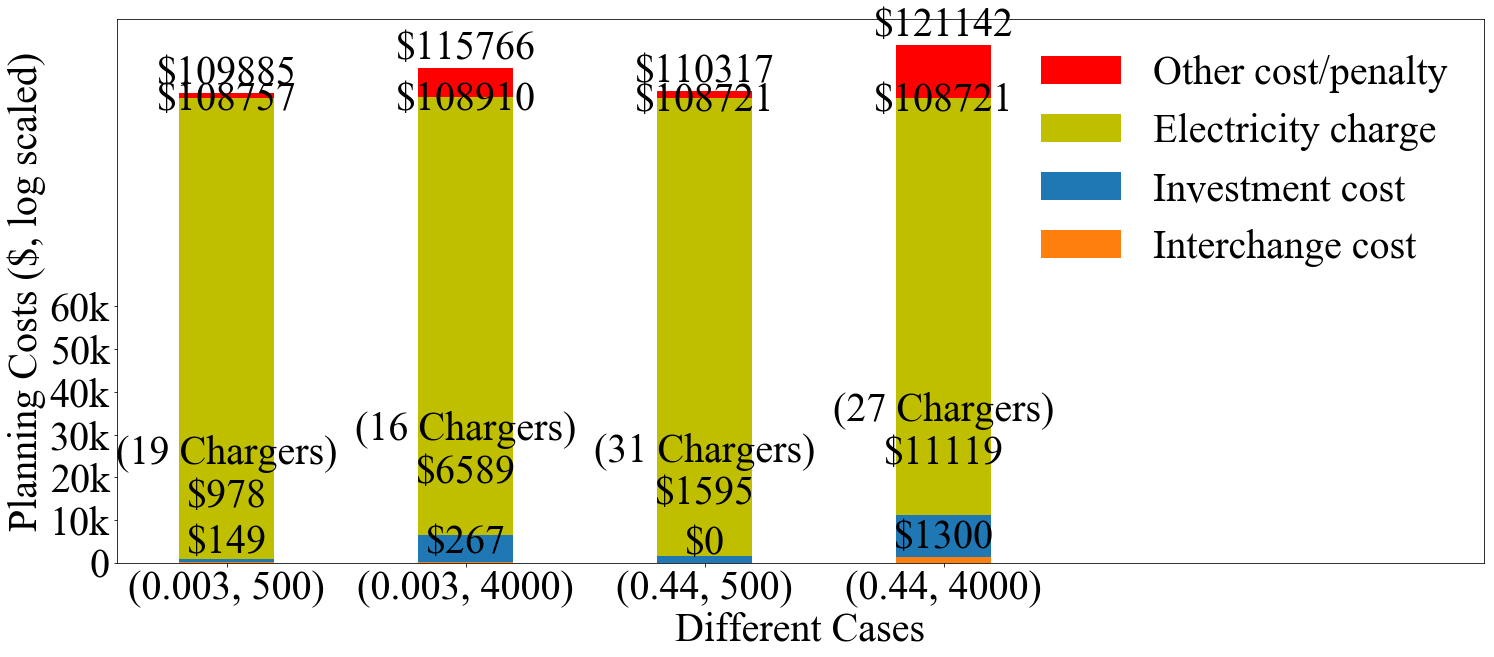

In [11]:
# Extract Results
itc_result = result_list_separate[0] + [0]

total_cost = result_list_separate[1]+[0]

inv_cost = result_list_separate[2]+[0]

elec_cost = result_list_separate[3]+[0]

elec_dem_cost = result_list_separate[4]+[0]

itc_cost = result_list_separate[5]+[0]

penalty_smooth = result_list_separate[6]+[0]

cost_tot_other = np.array(elec_cost) + np.array(elec_dem_cost) + np.array(penalty_smooth)

# Plot results
plt.figure(figsize=(24.5, 10))
plt.rc("font", size = 40, family = "Times New Roman")

totCost_xaxis = [0, 1, 2, 3, 4.8]
inv_Cost_xaxis = [0, 1, 2, 3, 4.8]
itc_Cost_xaxis = [0, 1, 2, 3, 4.8]

bar1 = plt.bar(totCost_xaxis, total_cost, width=0.4, label="Other cost/penalty", log=False, color = 'r')
# plt.bar(totCost_xaxis, elec_cost, width=0.4, label="Electricity cost", log=True)
# plt.bar(totCost_xaxis, elec_dem_cost, width=0.4, label="Demand charge", log=True)
bar4 = plt.bar(totCost_xaxis, cost_tot_other, width=0.4, label="Electricity charge", log=False, color = 'y')
bar2 = plt.bar(inv_Cost_xaxis, inv_cost, width=0.4, label="Investment cost", log=False)
bar3 = plt.bar(itc_Cost_xaxis, itc_cost, width=0.4, label="Interchange cost", log=False)

# plt.bar(totCost_xaxis, penalty_smooth, width=0.2, label="Smoothing penalty", log=True)

plt.xticks([0, 1, 2, 3], ["(0.003, 500)", "(0.003, 4000)", "(0.44, 500)", "(0.44, 4000)"])
plt.xlabel("Different Cases")
plt.ylabel("Planning Costs ($, log scaled)")
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000,], ["0", "10k", "20k", "30k", "40k", "50k", "60k"])

#add text to total cost bar
idx = 0
for rect in bar1[:-1]:
    height = rect.get_height() #1300000
    plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (total_cost[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
#add text to investment cost bar
idx = 0
for rect in bar2[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height+10000, '$%d' % (inv_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    if idx == 0:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    else:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
        
    idx += 1
    
#add text to interchange cost bar
idx = 0
for rect in bar3[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    if idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx > 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+60, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1

#add text to electricty cost bar
idx = 0
for rect in bar4[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height-5000, '$%d' % (cost_tot_other[idx][0]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
    
plt.legend(fontsize=40, framealpha=0)

## $\epsilon$ = 0.2

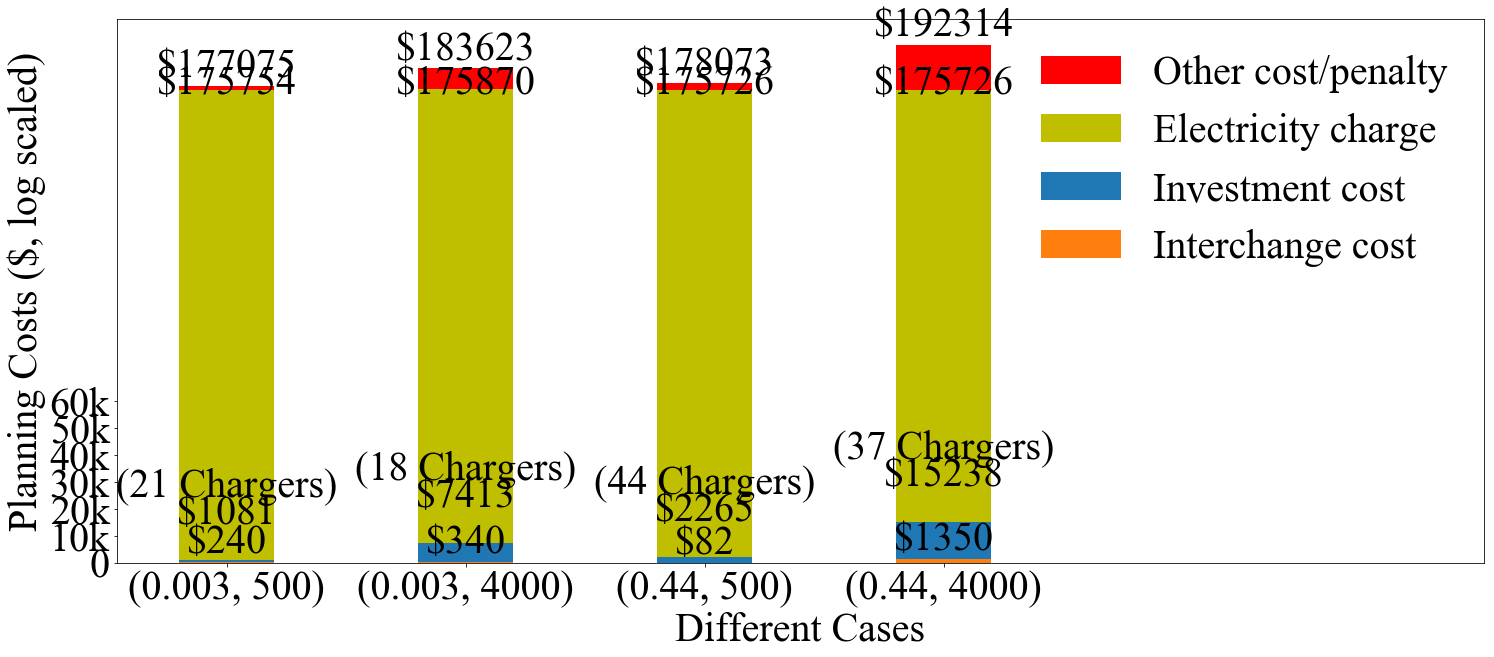

In [50]:
# Extract Results
itc_result = result_list_separate[0] + [0]

total_cost = result_list_separate[1]+[0]

inv_cost = result_list_separate[2]+[0]

elec_cost = result_list_separate[3]+[0]

elec_dem_cost = result_list_separate[4]+[0]

itc_cost = result_list_separate[5]+[0]

penalty_smooth = result_list_separate[6]+[0]

cost_tot_other = np.array(elec_cost) + np.array(elec_dem_cost) + np.array(penalty_smooth)

# Plot results
plt.figure(figsize=(24.5, 10))
plt.rc("font", size = 40, family = "Times New Roman")

totCost_xaxis = [0, 1, 2, 3, 4.8]
inv_Cost_xaxis = [0, 1, 2, 3, 4.8]
itc_Cost_xaxis = [0, 1, 2, 3, 4.8]

bar1 = plt.bar(totCost_xaxis, total_cost, width=0.4, label="Other cost/penalty", log=False, color = 'r')
# plt.bar(totCost_xaxis, elec_cost, width=0.4, label="Electricity cost", log=True)
# plt.bar(totCost_xaxis, elec_dem_cost, width=0.4, label="Demand charge", log=True)
bar4 = plt.bar(totCost_xaxis, cost_tot_other, width=0.4, label="Electricity charge", log=False, color = 'y')
bar2 = plt.bar(inv_Cost_xaxis, inv_cost, width=0.4, label="Investment cost", log=False)
bar3 = plt.bar(itc_Cost_xaxis, itc_cost, width=0.4, label="Interchange cost", log=False)

# plt.bar(totCost_xaxis, penalty_smooth, width=0.2, label="Smoothing penalty", log=True)

plt.xticks([0, 1, 2, 3], ["(0.003, 500)", "(0.003, 4000)", "(0.44, 500)", "(0.44, 4000)"])
plt.xlabel("Different Cases")
plt.ylabel("Planning Costs ($, log scaled)")
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000,], ["0", "10k", "20k", "30k", "40k", "50k", "60k"])

#add text to total cost bar
idx = 0
for rect in bar1[:-1]:
    height = rect.get_height() #1300000
    plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (total_cost[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
#add text to investment cost bar
idx = 0
for rect in bar2[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height+10000, '$%d' % (inv_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    if idx == 0:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    else:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+20000, '(%d Chargers)' % (itc_result[idx]), 
                 ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
        
    idx += 1
    
#add text to interchange cost bar
idx = 0
for rect in bar3[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    if idx <= 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    elif idx > 1:
        plt.text(rect.get_x()+rect.get_width()/2.0, height+60, '$%d' % (itc_cost[idx]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1

#add text to electricty cost bar
idx = 0
for rect in bar4[:-1]:
    height = rect.get_height()
    ##---- 50 PEVs
    plt.text(rect.get_x()+rect.get_width()/2.0, height-5000, '$%d' % (cost_tot_other[idx][0]), 
             ha='center', va='bottom', fontdict={'fontsize':40, 'weight':'bold'})
    idx += 1
    
plt.legend(fontsize=40, framealpha=0)